<a href="https://www.kaggle.com/code/amirmotefaker/scraping-twitter?scriptVersionId=130559819" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Why Scrape Twitter?

- [Twitter](https://twitter.com/Twitter) is a major announcement hub where people and companies publish their announcements. This is a great opportunity to use Twitter to follow industry trends. For example, stock market or crypto market targets could be scraped to predict the future price of a stock or crypto.

- Twitter is also a great source of data for sentiment analysis. You can use Twitter to find out what people think about a certain topic or brand. This is useful for market research, product development, and brand awareness.

- So, if we can scrape Twitter data with Python we can have access to this valuable public information for free!

# Twitter Scraping in 2023

- Twitter is one of the most popular social media platforms, with millions of users tweeting and sharing their thoughts and opinions every day. As a result, Twitter has become a valuable source of data for businesses, researchers, and developers who want to analyze user behavior, sentiment, and trends.

- The best way to get the data from Twitter is to use their official API. However, Twitter's API is becoming more and more restrictive: you can only get a limited amount of data from Twitter using their API. On top of that even the lowest tier of the API will require a monthly payment soon. That's why many people are looking for ways to scrape Twitter without these restrictions.

[webscraping.ai](https://webscraping.ai/blog/twitter-scraping-in-2023)

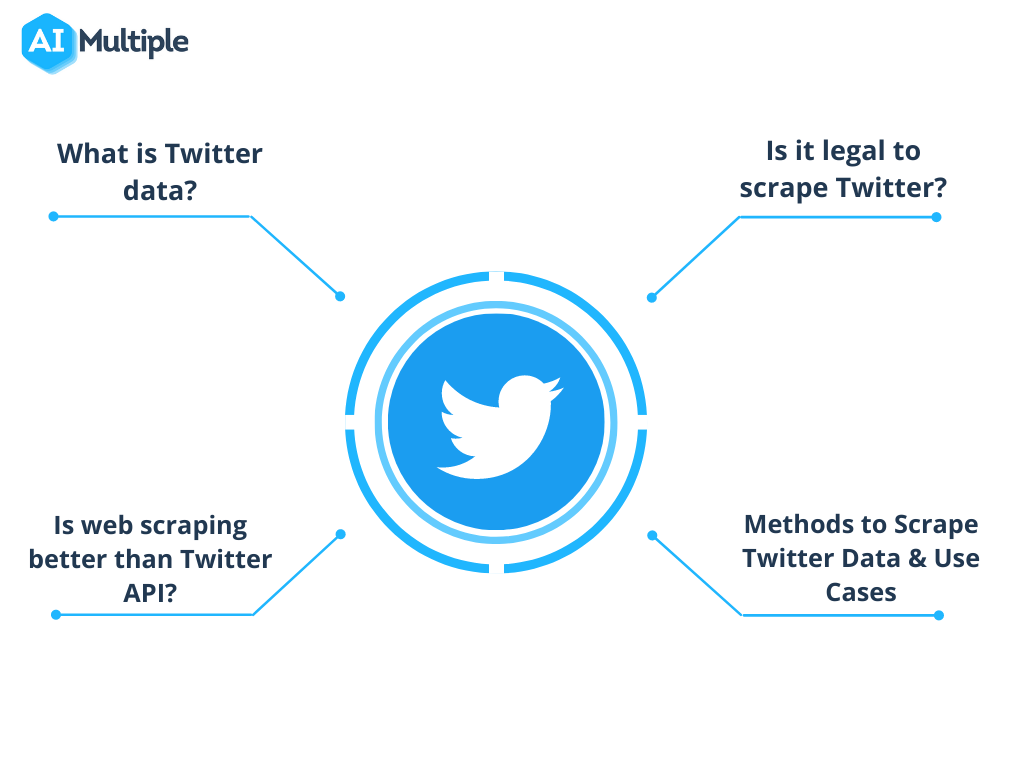

# Setup Wizard

- We'll approach Twitter scraping in three ways:

  - We'll be using [browser automation toolkit Playwright](https://scrapfly.io/blog/web-scraping-with-playwright-and-python/)
    - This is the easiest way to scrape Twitter as we are using real web browser, so all we have to do is navigate to url, wait for page to load and get the results.

  - We'll also take a look at reverse engineering Twitter's hidden API.
This will be a bit harder but these type of scrapers will be much faster than the browser ones. For this we'll be using [httpx](https://pypi.org/project/httpx/).

  - For ScrapFly users we'll also take a look at ScrapFly SDK which makes the above methods even easier.


- We'll be working with both JSON and HTML response data. So, we'll be using [parsel](https://pypi.org/project/parsel/) to parse HTML and [jamespath for JSON](https://scrapfly.io/blog/parse-json-jmespath-python/).

#### All of these libraries are available for free and can be installed via the pip install terminal command:

   $ pip install httpx playwright parsel jmespath scrapfly-sdk

In [ ]:
!pip install Scrapy
!pip install httpx playwright parsel jmespath asyncio gevent scrapfly-sdk

# Scraping Tweets

- Twitter is a complicated javascript web application that requires javascript to work. So, for tweet scraping we'll be using [Playwright](https://playwright.dev/) browser automation library.

#### Playwright-based Twitter scraper in Python should look something like this:

  1- We'll start a headless Chrome browser

  2- Navigate it to Tweet page URL like https://twitter.com/Scrapfly_dev/status/1577664612908077062

  3- Wait for the page to load

  4- Retrieve page HTML source

  5- Load HTML to "parsel.Selector"

  6- Use CSS selectors and XPath to extract Tweet details and replies

# Python

In [ ]:
from parsel import Selector
from playwright.sync_api import sync_playwright
from playwright.sync_api._generated import Page


def parse_tweets(selector: Selector):
    """
    parse tweets from pages containing tweets like:
    - tweet page
    - search page
    - reply page
    - homepage
    returns list of tweets on the page where 1st tweet is the 
    main tweet and the rest are replies
    """
    results = []
    # select all tweets on the page as individual boxes
    # each tweet is stored under <article data-testid="tweet"> box:
    tweets = selector.xpath("//article[@data-testid='tweet']")
    for i, tweet in enumerate(tweets):
        # using data-testid attribute we can get tweet details:
        found = {
            "text": "".join(tweet.xpath(".//*[@data-testid='tweetText']//text()").getall()),
            "username": tweet.xpath(".//*[@data-testid='User-Names']/div[1]//text()").get(),
            "handle": tweet.xpath(".//*[@data-testid='User-Names']/div[2]//text()").get(),
            "datetime": tweet.xpath(".//time/@datetime").get(),
            "verified": bool(tweet.xpath(".//svg[@data-testid='icon-verified']")),
            "url": tweet.xpath(".//time/../@href").get(),
            "image": tweet.xpath(".//*[@data-testid='tweetPhoto']/img/@src").get(),
            "video": tweet.xpath(".//video/@src").get(),
            "video_thumb": tweet.xpath(".//video/@poster").get(),
            "likes": tweet.xpath(".//*[@data-testid='like']//text()").get(),
            "retweets": tweet.xpath(".//*[@data-testid='retweet']//text()").get(),
            "replies": tweet.xpath(".//*[@data-testid='reply']//text()").get(),
            "views": (tweet.xpath(".//*[contains(@aria-label,'Views')]").re("(\d+) Views") or [None])[0],
        }
        # main tweet (not a reply):
        if i == 0:
            found["views"] = tweet.xpath('.//span[contains(text(),"Views")]/../preceding-sibling::div//text()').get()
            found["retweets"] = tweet.xpath('.//a[contains(@href,"retweets")]//text()').get()
            found["quote_tweets"] = tweet.xpath('.//a[contains(@href,"retweets/with_comments")]//text()').get()
            found["likes"] = tweet.xpath('.//a[contains(@href,"likes")]//text()').get()
        results.append({k: v for k, v in found.items() if v is not None})
    return results


def scrape_tweet(url: str, page: Page):
    """
    Scrape tweet and replies from tweet page like:
    https://twitter.com/Scrapfly_dev/status/1587431468141318146
    """
    # go to url
    page.goto(url)
    # wait for content to load
    page.wait_for_selector("//article[@data-testid='tweet']")  
    # retrieve final page HTML:
    html = page.content()
    # parse it for data:
    selector = Selector(html)
    tweets = parse_tweets(selector)
    return tweets


# # example run:
# with sync_playwright() as pw:
#     # start browser and open a new tab:
#     browser = pw.chromium.launch(headless=False)
#     page = browser.new_page(viewport={"width": 1920, "height": 1080})
#     # scrape tweet and replies:
#     tweet_and_replies = scrape_tweet("httpTrutwitter.com/Scrapfly_dev/status/1587431468141318146", page)
#     print(tweet_and_replies)


# example
from playwright.async_api import async_playwright # need to import this first
from gevent import monkey, spawn
import asyncio
import gevent

monkey.patch_all()
loop = asyncio.new_event_loop()


async def f():
    print("start")
    playwright = await async_playwright().start()
    browser = await playwright.chromium.launch(headless=True)
    context = await browser.new_context()
    page = await context.new_page()
    await page.goto(f"https://www.google.com")
    print("done")


def greeny():
    while True:  # and not other_exit_condition
        future = asyncio.run_coroutine_threadsafe(f(), loop)
        while not future.done():
            gevent.sleep(1)


greenlet1 = spawn(greeny)
greenlet2 = spawn(greeny)
#loop.run_forever()

# ScrapFly

In [ ]:
import sys
print(sys.getrecursionlimit())

In [ ]:
from parsel import Selector
from scrapfly import ScrapflyClient, ScrapeConfig

#scrapfly = ScrapflyClient(key="YOUR SCRAPFLY KEY")
scrapfly = ScrapflyClient(key="scp-live-f35fc29bbb4d476bb1084e6ae155260d")


def parse_tweets(selector: Selector):
    """
    parse tweets from pages containing tweets like:
    - tweet page
    - search page
    - reply page
    - homepage
    returns list of tweets on the page where 1st tweet is the
    main tweet and the rest are replies
    """
    results = []
    # select all tweets on the page as individual boxes
    # each tweet is stored under <article data-testid="tweet"> box:
    tweets = selector.xpath("//article[@data-testid='tweet']")
    for i, tweet in enumerate(tweets):
        # using data-testid attribute we can get tweet details:
        found = {
            "text": "".join(tweet.xpath(".//*[@data-testid='tweetText']//text()").getall()),
            "username": tweet.xpath(".//*[@data-testid='User-Names']/div[1]//text()").get(),
            "handle": tweet.xpath(".//*[@data-testid='User-Names']/div[2]//text()").get(),
            "datetime": tweet.xpath(".//time/@datetime").get(),
            "verified": bool(tweet.xpath(".//svg[@data-testid='icon-verified']")),
            "url": tweet.xpath(".//time/../@href").get(),
            "image": tweet.xpath(".//*[@data-testid='tweetPhoto']/img/@src").get(),
            "video": tweet.xpath(".//video/@src").get(),
            "video_thumb": tweet.xpath(".//video/@poster").get(),
            "likes": tweet.xpath(".//*[@data-testid='like']//text()").get(),
            "retweets": tweet.xpath(".//*[@data-testid='retweet']//text()").get(),
            "replies": tweet.xpath(".//*[@data-testid='reply']//text()").get(),
            "views": (tweet.xpath(".//*[contains(@aria-label,'Views')]").re("(\d+) Views") or [None])[0],
        }
        # main tweet (not a reply):
        if i == 0:
            found["views"] = tweet.xpath('.//span[contains(text(),"Views")]/../preceding-sibling::div//text()').get()
            found["retweets"] = tweet.xpath('.//a[contains(@href,"retweets")]//text()').get()
            found["quote_tweets"] = tweet.xpath('.//a[contains(@href,"retweets/with_comments")]//text()').get()
            found["likes"] = tweet.xpath('.//a[contains(@href,"likes")]//text()').get()
        results.append({k: v for k, v in found.items() if v is not None})
    return results


def scrape_tweet(url: str):
    """
    Scrape tweet and replies from tweet page like:
    https://twitter.com/Scrapfly_dev/status/1587431468141318146
    """
    result = scrapfly.scrape(ScrapeConfig(
        url=url,
        country="US",
        render_js=True,
    ))
    return parse_tweets(result.selector)


tweet_and_replies = scrape_tweet("https://twitter.com/Google/status/1622686179077357573")
print(tweet_and_replies)

# Scraping Search

- Twitter is known for its powerful search engine and it's a great place to find popular tweets and users.

- To scrape Twitter search we'll use Playwright as well. Our process looks very similar to our previous scraper:

  1- We'll start a headless Chrome browser

  2- Navigate it to Tweet search page url like https://twitter.com/Scrapfly_dev/status/1587431468141318146
  
  3- Wait for the page to load

  4- Retrieve page HTML source

  5- Load HTML to parsel.Selector

  6- Use CSS selectors and XPath to find Tweets or Twitter users


  - For this example, we'll cover two search endpoints:

    - People Search - scrape people profiles related to the search query.
    - Top Results - scrape recommended tweets and profiles related to the search query.

In [ ]:
from parsel import Selector
from playwright.sync_api import sync_playwright
from playwright.sync_api._generated import Page

def parse_profiles(sel: Selector):
    """parse profile preview data from Twitter profile search"""
    profiles = []
    for profile in sel.xpath("//div[@data-testid='UserCell']"):
        profiles.append(
            {
                "name": profile.xpath(".//a[not(@tabindex=-1)]//text()").get().strip(),
                "handle": profile.xpath(".//a[@tabindex=-1]//text()").get().strip(),
                "bio": ''.join(profile.xpath("(.//div[@dir='auto'])[last()]//text()").getall()),
                "url": profile.xpath(".//a/@href").get(),
                "image": profile.xpath(".//img/@src").get(),
            }
        )
    return profiles


def scrape_top_search(query: str, page: Page):
    """scrape top Twitter page for featured tweets"""
    page.goto(f"https://twitter.com/search?q={query}&src=typed_query")
    page.wait_for_selector("//article[@data-testid='tweet']")  # wait for content to load
    tweets = parse_tweets(Selector(page.content()))
    return tweets


def scrape_people_search(query: str, page: Page):
    """scrape people search Twitter page for related users"""
    page.goto(f"https://twitter.com/search?q={query}&src=typed_query&f=user")
    page.wait_for_selector("//div[@data-testid='UserCell']")  # wait for content to load
    profiles = parse_profiles(Selector(page.content()))
    return profiles


# with sync_playwright() as pw:
#     browser = pw.chromium.launch(headless=False)
#     page = browser.new_page(viewport={"width": 1920, "height": 1080})
    
#     top_tweet_search = scrape_top_search("google", page)
#     people_tweet_search = scrape_people_search("google", page)


from playwright.async_api import async_playwright # need to import this first
from gevent import monkey, spawn
import asyncio
import gevent

monkey.patch_all()
loop = asyncio.new_event_loop()


async def f():
    print("start")
    playwright = await async_playwright().start()
    browser = await playwright.chromium.launch(headless=True)
    context = await browser.new_context()
    page = await context.new_page()
    await page.goto(f"https://www.google.com")
    print("done")


def greeny():
    while True:  # and not other_exit_condition
        future = asyncio.run_coroutine_threadsafe(f(), loop)
        while not future.done():
            gevent.sleep(1)


greenlet1 = spawn(greeny)
greenlet2 = spawn(greeny)
#loop.run_forever()

# ScrapFly

In [ ]:
import json
from parsel import Selector
from playwright.sync_api import sync_playwright
from playwright.sync_api._generated import Page
#from snippet1 import parse_tweets  # we covered tweet parsing in previous code snippet!
from scrapfly import ScrapflyClient, ScrapeConfig

#scrapfly = ScrapflyClient(key="YOUR SCRAPFLY KEY")
scrapfly = ScrapflyClient(key="scp-live-f35fc29bbb4d476bb1084e6ae155260d")



def parse_profiles(sel: Selector):
    """parse profile preview data from Twitter profile search"""
    profiles = []
    for profile in sel.xpath("//div[@data-testid='UserCell']"):
        profiles.append(
            {
                "name": profile.xpath(".//a[not(@tabindex=-1)]//text()").get().strip(),
                "handle": profile.xpath(".//a[@tabindex=-1]//text()").get().strip(),
                "bio": "".join(profile.xpath("(.//div[@dir='auto'])[last()]//text()").getall()),
                "url": profile.xpath(".//a/@href").get(),
                "image": profile.xpath(".//img/@src").get(),
            }
        )
    return profiles


def scrape_top_search(query: str):
    """scrape top Twitter page for featured tweets"""
    result = scrapfly.scrape(
        ScrapeConfig(
            url=f"https://twitter.com/search?q={query}&src=typed_query",
            country="US",
            render_js=True,
        )
    )
    return parse_tweets(result.selector)


def scrape_people_search(query: str):
    """scrape people search Twitter page for related users"""
    result = scrapfly.scrape(
        ScrapeConfig(
            url=f"https://twitter.com/search?q={query}&src=typed_query&f=user",
            country="US",
            render_js=True,
        )
    )
    return parse_profiles(result.selector)


if __name__ == "__main__":
    top_tweet_search = scrape_top_search("google")
    print(json.dumps(top_tweet_search, indent=2))
    people_tweet_search = scrape_people_search("google")
    print(json.dumps(people_tweet_search, indent=2))